# Diffusion 2D Unconditional Example

This notebook demonstrates how to train and sample from a diffusion model on a 2D toy dataset using JAX and Flax. We will cover data generation, model definition, training, sampling, and visualization.

## 1. Environment Setup

In this section, we set up the notebook environment, import required libraries, and configure JAX for CPU or GPU usage.

In [ ]:
# Load autoreload extension for development convenience
%load_ext autoreload
%autoreload 2

In [ ]:
try: #check if we are using colab, if so install all the required software
    import google.colab
    colab=True
except:
    colab=False

In [ ]:
if colab:  # you may have to restart the runtime after installing the packages
    !pip install "gensbi_examples[cuda12] @ git+https://github.com/aurelio-amerio/GenSBI-examples"
    !git clone https://github.com/aurelio-amerio/GenSBI-examples
    %cd GenSBI-examples/examples

In [ ]:
# Set training and model restoration flags
overwrite_model=False
restore_model=True
train_model=False

In [ ]:
# Import libraries and set JAX backend
import os
os.environ['JAX_PLATFORMS']="cpu"
# os.environ['JAX_PLATFORMS']="cuda"

import sys
sys.path.append("./src")

from flax import nnx
import jax
import jax.numpy as jnp
import optax
from optax.contrib import reduce_on_plateau
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
from matplotlib import cm

import time
import diffrax

import grain.python as grain

In [ ]:
# Setup checkpoint directory and JAX sharding mesh
import orbax.checkpoint as ocp
pwd = os.getcwd()
checkpoint_dir = f"{pwd}/checkpoints/diffusion_2d_example"

os.makedirs(checkpoint_dir, exist_ok=True)

if overwrite_model:
    checkpoint_dir = ocp.test_utils.erase_and_create_empty(checkpoint_dir)

# Define the mesh for JAX sharding (for model restoration on CPU/GPU)
devices = jax.devices()
mesh = jax.sharding.Mesh(devices, axis_names=('data',)) # A simple 1D mesh

## 2. Data Generation

We generate a synthetic 2D dataset using JAX. This section defines the data generation functions and visualizes the data distribution.

In [ ]:
# Define data generation functions for moons and boxes datasets
import jax
import jax.numpy as jnp
from jax import random
from functools import partial

@partial(jax.jit, static_argnums=[1,2,3])  # type: ignore
def make_moons_jax(key, n_samples=100, shuffle=True, noise=None):
    """Make two interleaving half circles using JAX.

    Args:
        n_samples: The total number of points generated.
        shuffle: Whether to shuffle the samples.
        noise: Standard deviation of Gaussian noise added to the data.
        random_state: A JAX random.PRNGKey for reproducibility.

    Returns:
        X: A JAX array of shape (n_samples, 2) containing the generated samples.
        y: A JAX array of shape (n_samples,) containing the integer labels (0 or 1)
           for class membership of each sample.
    """

    n_samples_out = n_samples // 2
    n_samples_in = n_samples - n_samples_out

    # Generate points for the outer moon (label 0)
    outer_circ_t = random.uniform(key, shape=(n_samples_out,)) * jnp.pi
    key, subkey = random.split(key)
    outer_circ_x = jnp.cos(outer_circ_t)
    outer_circ_y = jnp.sin(outer_circ_t)
    X_outer = jnp.vstack([outer_circ_x, outer_circ_y]).T

    # Generate points for the inner moon (label 1)
    inner_circ_t = random.uniform(subkey, shape=(n_samples_in,)) * jnp.pi
    key, subkey = random.split(key)
    inner_circ_x = 1 - jnp.cos(inner_circ_t)
    inner_circ_y = 0.5 - jnp.sin(inner_circ_t)
    X_inner = jnp.vstack([inner_circ_x, inner_circ_y]).T

    # Combine the moons
    X = jnp.vstack([X_outer, X_inner])
    y = jnp.hstack([jnp.zeros(n_samples_out, dtype=jnp.int32), jnp.ones(n_samples_in, dtype=jnp.int32)])

    if noise is not None:
        # Add Gaussian noise
        key, subkey = random.split(key)
        X += random.normal(subkey, shape=X.shape) * noise

    if shuffle:
        # Shuffle the data
        key, subkey = random.split(key)
        permutation = random.permutation(subkey, n_samples)
        X = X[permutation]
        y = y[permutation]

    return X, y



@partial(jax.jit, static_argnums=[1])  # type: ignore
def make_boxes_jax(key, batch_size: int = 200):
    """
    Generates a batch of 2D data points similar to the original PyTorch function
    using JAX.

    Args:
        key: A JAX PRNG key for random number generation.
        batch_size: The number of data points to generate.

    Returns:
        A JAX array of shape (batch_size, 2) with generated data,
        with dtype float32.
    """
    # Split the key for different random operations
    keys = jax.random.split(key, 3)
    x1 = jax.random.uniform(keys[0],batch_size) * 4 - 2
    x2_ = jax.random.uniform(keys[1],batch_size) - jax.random.randint(keys[2], batch_size, 0,2) * 2
    x2 = x2_ + (jnp.floor(x1) % 2)

    data = 1.0 * jnp.concatenate([x1[:, None], x2[:, None]], axis=1) / 0.45

    return data

In [ ]:
# Infinite data generator for training batches
@partial(jax.jit, static_argnums=[1])  # type: ignore
def inf_train_gen(key, batch_size: int = 200):
    x = make_boxes_jax(key, batch_size)
    return x

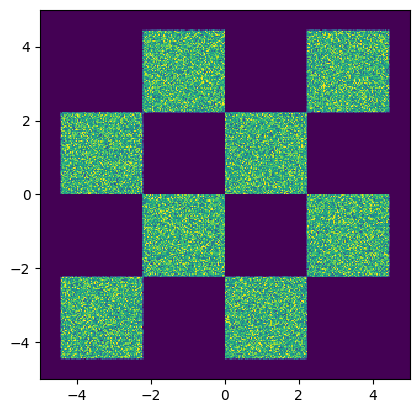

In [ ]:
# Visualize the generated data distribution
samples = inf_train_gen(jax.random.PRNGKey(0), 500_000)

H=plt.hist2d(samples[:,0], samples[:,1], 300, range=((-5,5), (-5,5)))
cmin = 0.0
cmax = jnp.quantile(jnp.array(H[0]), 0.99).item()
norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

_ = plt.hist2d(samples[:,0], samples[:,1], 300, range=((-5,5), (-5,5)), norm=norm)

# set equal ratio of axes
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## 3. Model and Loss Definition

We define the score model (an MLP), the loss function, and the optimizer for training the diffusion model.

In [ ]:
# Import diffusion model components and utilities
from gensbi.utils.model_wrapping import ModelWrapper
from gensbi.diffusion.path import EDMPath
from gensbi.diffusion.path.scheduler import EDMScheduler
from gensbi.diffusion.solver import SDESolver

In [ ]:
# Define the MLP score model
class MLP(nnx.Module):
    def __init__(self, input_dim: int = 2, hidden_dim: int = 128, *, rngs: nnx.Rngs):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        din = input_dim + 1

        self.linear1 = nnx.Linear(din, self.hidden_dim, rngs=rngs)
        self.linear2 = nnx.Linear(self.hidden_dim, self.hidden_dim, rngs=rngs)
        self.linear3 = nnx.Linear(self.hidden_dim, self.hidden_dim, rngs=rngs)
        self.linear4 = nnx.Linear(self.hidden_dim, self.hidden_dim, rngs=rngs)
        self.linear5 = nnx.Linear(self.hidden_dim, self.input_dim, rngs=rngs)

    def __call__(self, x: jax.Array, t: jax.Array):
        x = jnp.atleast_2d(x)
        t = jnp.atleast_1d(t)
        if len(t.shape)<2:
            t = t[..., None]
            t = jnp.broadcast_to(t, (x.shape[0], t.shape[-1]))

        h = jnp.concatenate([x, t], axis=-1)

        x = self.linear1(h)
        x = jax.nn.gelu(x)

        x = self.linear2(x)
        x = jax.nn.gelu(x)

        x = self.linear3(x)
        x = jax.nn.gelu(x)

        x = self.linear4(x)
        x = jax.nn.gelu(x)

        x = self.linear5(x)

        return x

In [ ]:
# Initialize the score model
hidden_dim = 512
F_model = MLP(input_dim=2, hidden_dim=hidden_dim, rngs=nnx.Rngs(0))

In [ ]:
# Define optimizer and learning rate schedule parameters
PATIENCE = 10
COOLDOWN = 5
FACTOR = 0.5
RTOL = 1e-4
ACCUMULATION_SIZE = 100
MAX_LR = 0.5e-3
MIN_LR = 0
MIN_SCALE = MIN_LR / MAX_LR

In [ ]:
# Set up optimizer with reduce-on-plateau schedule
nsteps = 10_000
nepochs = 5

multistep = 1

opt = optax.chain(
    optax.adaptive_grad_clip(10.0),
    optax.adamw(MAX_LR),
    reduce_on_plateau(
        patience=PATIENCE,
        cooldown=COOLDOWN,
        factor=FACTOR,
        rtol=RTOL,
        accumulation_size=ACCUMULATION_SIZE,
        min_scale=MIN_SCALE,
    ),
)
if multistep > 1:
    opt = optax.MultiSteps(opt, multistep)
optimizer = nnx.Optimizer(F_model, opt)

In [ ]:
# Restore the model from checkpoint if requested
if restore_model:
    checkpointer = ocp.StandardCheckpointer()
    abs_model = nnx.eval_shape(lambda: MLP(input_dim=2, hidden_dim=hidden_dim, rngs=nnx.Rngs(0)))
    abs_state = nnx.state(abs_model)
    # Orbax API expects a tree of abstract `jax.ShapeDtypeStruct`
    # that contains both sharding and the shape/dtype of the arrays.
    abs_state = jax.tree.map(
        lambda a, s: jax.ShapeDtypeStruct(a.shape, a.dtype, sharding=s),
        abs_state, nnx.get_named_sharding(abs_state, mesh)
    )
    loaded_sharded = checkpointer.restore(checkpoint_dir + '/v1',
                                         target=abs_state)

    graphdef, abstract_state = nnx.split(abs_model)
    F_model = nnx.merge(graphdef, loaded_sharded)
    checkpointer.close()

## 4. Training Loop

This section defines the training and validation steps, and runs the training loop if enabled. Early stopping and learning rate scheduling are used for efficient training.

In [ ]:
# Set batch size for training
batch_size = 1024

In [ ]:
# Instantiate the diffusion path and loss function
path = EDMPath(scheduler=EDMScheduler())
loss_fn = path.get_loss_fn()

In [ ]:
# Generate validation data
val_data = inf_train_gen(jax.random.PRNGKey(1), 512)

In [ ]:
# Validation loss computation
@nnx.jit
def val_loss(model, key):
    x_1 = val_data
    sigma = path.sample_sigma(key, x_1.shape[0])
    path_sample = path.sample(key, x_1, sigma)
    batch = path_sample.get_batch()
    loss = loss_fn(model, batch)
    return loss

In [ ]:
# Training step function
@nnx.jit
def train_step(F_model, optimizer, batch):
    grad_fn = nnx.value_and_grad(loss_fn)
    loss, grads = grad_fn(F_model, batch)
    optimizer.update(grads, value=loss)  # In-place updates.
    return loss

In [ ]:
# Import tqdm for progress bars and set early stopping flag
from tqdm import tqdm
early_stopping = True

In [ ]:
# Initialize training state and tracking variables
best_state = nnx.state(F_model)
best_val_loss_value = val_loss(F_model, jax.random.PRNGKey(0))
val_error_ratio = 1.1
counter = 0
cmax = 10
print_every = 100

loss_array = []
val_loss_array = []

rngs = nnx.Rngs(42)

In [ ]:
# Main training loop (runs only if train_model=True)
if train_model:
    F_model.train()

    for ep in range(nepochs):
        pbar = tqdm(range(nsteps))
        l = 0
        v_l = 0
        for j in pbar:
            if counter > cmax and early_stopping:
                print("Early stopping")
                # restore the model state to the best found so far
                graphdef, abstract_state = nnx.split(F_model)
                F_model = nnx.merge(graphdef, best_state)
                break

            # Generate a batch of target data x_1 from the data generator
            x_1 = inf_train_gen(rngs.train_step(), batch_size)
            # Sample noise levels and create path sample
            sigma = path.sample_sigma(rngs.train_step(), x_1.shape[0])
            path_sample = path.sample(rngs.train_step(), x_1, sigma)
            batch = path_sample.get_batch()

            # Compute loss and update model parameters in-place
            loss = train_step(F_model, optimizer, batch)
            l += loss.item()

            # Compute validation loss for early stopping and LR scheduling
            v_loss = val_loss(F_model, rngs.val_step())
            v_l += v_loss.item()

            if j > 0 and j % 100 == 0:
                # Compute average training and validation loss over the last 100 steps
                loss_ = l / 100
                val_ = v_l / 100

                # Compute ratios for early stopping and best model tracking
                ratio1 = val_ / loss_
                ratio2 = val_ / best_val_loss_value

                # If validation loss is not diverging, update best state if needed
                if ratio1 < val_error_ratio:
                    if val_ < best_val_loss_value:
                        best_val_loss_value = val_
                        best_state = nnx.state(F_model)
                    elif ratio2 < 1.05:
                        best_state = nnx.state(F_model)

                    counter = 0
                else:
                    counter += 1

                # Update progress bar with current metrics
                pbar.set_postfix(
                    loss=f"{loss_:.4f}",
                    ratio=f"{ratio1:.4f}",
                    counter=counter,
                    val_loss=f"{val_:.4f}",
                )
                loss_array.append(loss_)
                val_loss_array.append(val_)
                l = 0
                v_l = 0

    F_model.eval()

In [ ]:
# Save the trained model to checkpoint (if training was performed)
if train_model:
    checkpointer = ocp.StandardCheckpointer()
    model_state = nnx.state(F_model)
    checkpointer.save(checkpoint_dir + '/v1', model_state)
    checkpointer.close()

## 5. Sampling from the Model

In this section, we sample trajectories from the trained diffusion model and visualize the results at different time steps.

# sample the model

In [ ]:
# Set model to evaluation mode before sampling
F_model.eval()

In [ ]:
# Sample trajectories from the model using SDE solver
nsteps = 30

norm = cm.colors.Normalize(vmax=50, vmin=0)

nsamples = 100_000  # batch size

key = jax.random.PRNGKey(0)

solver = SDESolver(score_model=F_model, path=path)  # create an SDESolver class
x_init = path.sample_prior(key, (nsamples,2) )  # sample initial points from the prior distribution
samples = solver.sample(key, x_init, nsteps=nsteps, return_intermediates=True)  # sample from the model

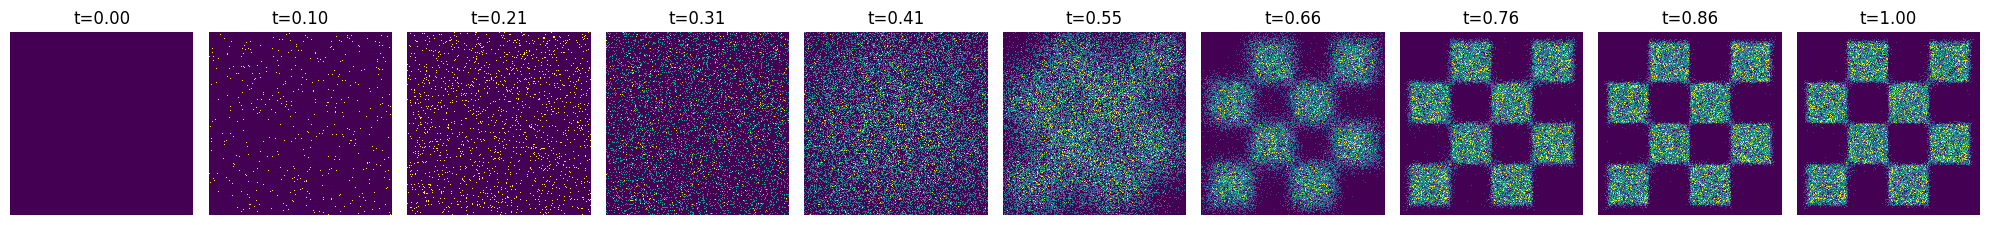

In [ ]:
# Visualize the sampled trajectories at different time steps
T = np.linspace(0, 29, 10, endpoint=True, dtype=int)  # convert to numpy array

fig, axs = plt.subplots(1, len(T), figsize=(20,20))

for i,step in enumerate(T):
    H = axs[i].hist2d(samples[step,:,0], samples[step,:,1], 300, range=((-5,5), (-5,5)))

    cmin = 0.0
    cmax = jnp.quantile(jnp.array(H[0]), 0.99).item()

    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

    _ = axs[i].hist2d(samples[step,:,0], samples[step,:,1], 300, range=((-5,5), (-5,5)), norm=norm)

    axs[i].set_aspect('equal')
    axs[i].axis('off')
    axs[i].set_title(f't={step/(nsteps-1):.2f}')

plt.tight_layout()
plt.show()

## 6. Marginal and Trajectory Visualization

We visualize the marginal distributions and sample trajectories from the diffusion model.

In [ ]:
# Import plotting utilities for marginals and trajectories
from gensbi.utils.plotting import plot_trajectories, plot_marginals

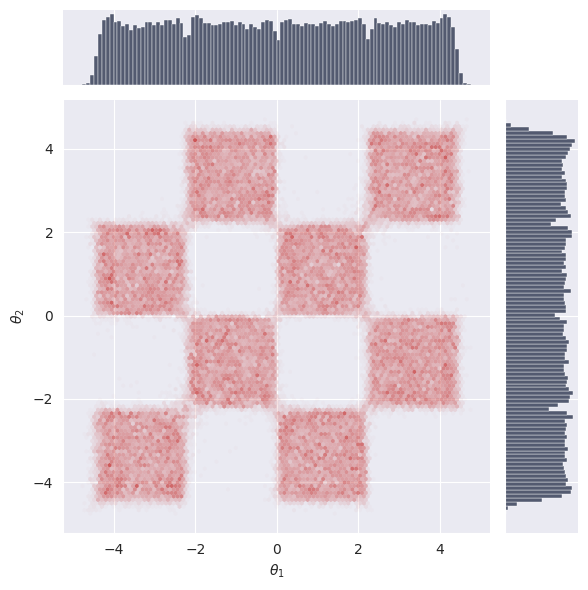

In [ ]:
# Plot the marginal distribution of the final samples
plot_marginals(samples[-1], plot_levels=False, gridsize=100)
plt.show()

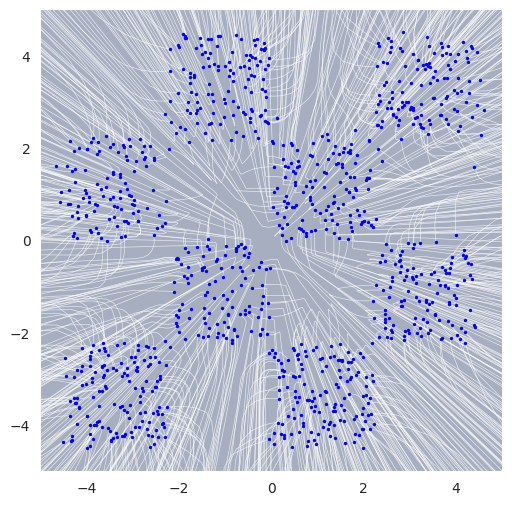

In [ ]:
# Plot sampled trajectories
fig, ax = plot_trajectories(samples[:,:1000,:])
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.grid(False)
plt.show()